In [115]:
import jupyter_black

jupyter_black.load()

In [68]:
from qlearning import QLearner
from grid_world import PickUpAndDeliver
import pandas as pd
import numpy as np

In [69]:
def reward(current_state, previous_state):
    position, damage, pickup = current_state
    _, previous_damage, _ = previous_state

    if damage == 5:
        return np.array([-25, -25])
    if position == 22 and pickup == True:
        return np.array([50, 50])
    if previous_damage < damage:
        return np.array([-1, -10])
    else:
        return np.array([-1, 0])


def update_state(state, actor_pos):
    terminal = False
    _, damage, pickup = state
    damage_pos = [0, 1, 11, 12, 16, 18, 23, 25, 30, 36, 39]
    if actor_pos in damage_pos:
        damage += 1
    if actor_pos == 19:
        pickup = True
    if (actor_pos == 22 and pickup) or damage == 5:
        terminal = True
    return (actor_pos, damage, pickup), terminal


def env():
    height = 6
    width = 7
    inital_state = (22, 0, False)
    return PickUpAndDeliver(inital_state, reward, update_state, 22, height, width)

In [70]:
def qlearner(
    learning_rate=0.1,
    discount_factor=0.9,
    explore_rate=0.01,
    weight_function=lambda x: x[0],
    objective=0,
):
    learner = QLearner(
        ["up", "down", "right", "left"],
        learning_rate,
        discount_factor,
        explore_rate,
        objectives=2,
        weight_function=weight_function,
    )
    episodes = list()
    for episode in range(1, 10000):
        totalValue = 0
        actions = list()
        world = env()
        learner.start_episode(world.current_state())

        end = False
        while end != True:
            action = learner.act(world.current_state())
            actions.append(action)
            value, end = world.act(action)
            totalValue += value[objective]
            learner.reward(value, world.current_state())

        learner.end_episode()
        episodes.append((episode, totalValue, actions))
    return learner, episodes


def episodes_to_df(
    episodes, columns=["episode", "total value", "actions"]
) -> pd.DataFrame:
    return pd.DataFrame(episodes, columns=columns)


def print_actions(episodes):
    for episode, totalValue, actions in episodes:
        print(
            "Episode: {}, total value: {}, actions: {}".format(
                episode, totalValue, actions
            )
        )

In [71]:
q1, q1_episodes = qlearner(explore_rate=0.01)
q1_df = episodes_to_df(q1_episodes)

q2, q2_episodes = qlearner(
    weight_function=lambda x: x[1], explore_rate=0.01, objective=1
)
q2_df = episodes_to_df(q2_episodes)

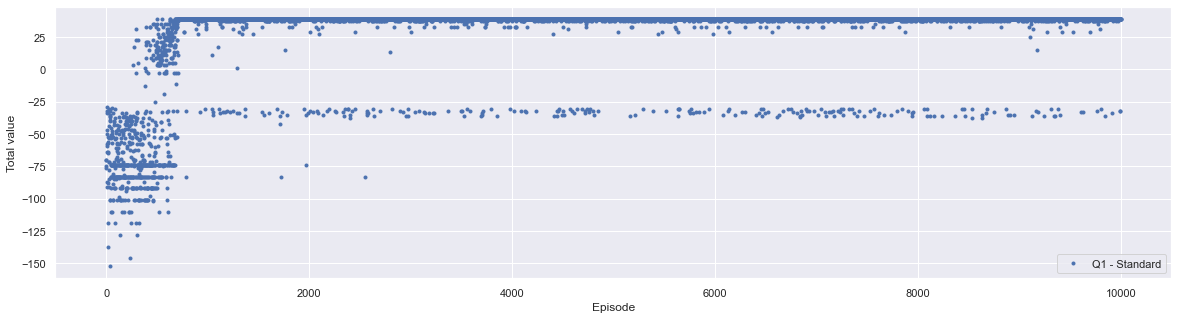

In [72]:
from matplotlib import pyplot

pyplot.figure(figsize=(20, 5))
pyplot.plot(range(1, 10000), q1_df["total value"], "b.")
pyplot.ylabel("Total value")
pyplot.xlabel("Episode")
pyplot.legend(["Q1 - Standard"])
pyplot.show()

In [73]:
q1_df

,episode,total value,actions
0,1,-75,"[up, up, up, up, down, up, up, down, up, up, d..."
1,2,-70,"[down, up, right, up, up, up, up, down, down, ..."
2,3,-76,"[left, up, up, up, up, down, up, up, down, up,..."
3,4,-70,"[up, down, down, down, up, up, up, up, down, d..."
4,5,-29,"[right, down, up, up, down]"
...,...,...,...
9994,9995,39,"[right, right, right, up, right, left, left, u..."
9995,9996,-32,"[right, right, right, up, right, left, left, r..."
9996,9997,39,"[right, right, right, up, right, left, left, u..."
9997,9998,39,"[right, right, right, up, right, left, left, u..."


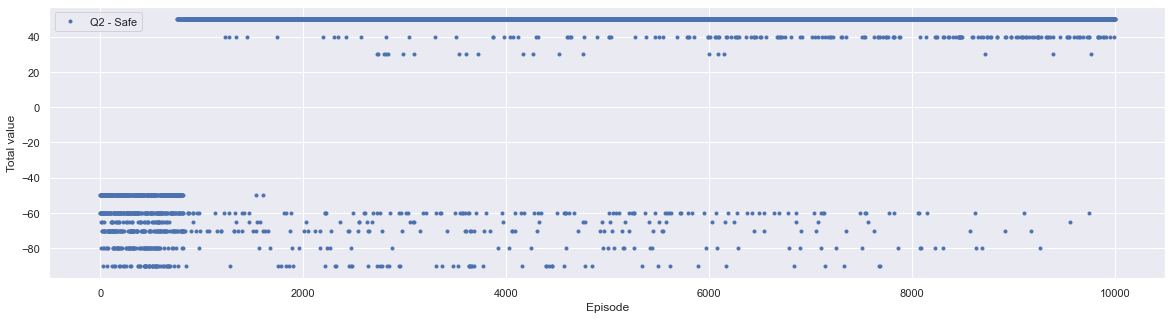

In [74]:
from matplotlib import pyplot

pyplot.figure(figsize=(20, 5))
pyplot.plot(range(1, 10000), q2_df["total value"], "b.")
pyplot.ylabel("Total value")
pyplot.xlabel("Episode")
pyplot.legend(["Q2 - Safe"])
pyplot.show()

In [75]:
q2_df

,episode,total value,actions
0,1,-60,"[up, up, up, up, up, up, up, up, up, up, up, u..."
1,2,-50,"[up, up, down, up, down, up, down, up, down, u..."
2,3,-50,"[up, down, up, down, up, down, up, down, up, d..."
3,4,-60,"[up, right, up, up, up, up, up, up, up, up, up..."
4,5,-60,"[up, left, up, up, up, up, up, up, up, up, up,..."
...,...,...,...
9994,9995,50,"[up, up, right, right, down, down, down, right..."
9995,9996,50,"[up, up, right, right, down, down, down, right..."
9996,9997,50,"[up, up, right, right, down, down, down, right..."
9997,9998,50,"[up, up, right, right, down, down, down, right..."


In [76]:
np.max(q2_df["total value"])

50

In [203]:
def create_state_value(
    q_table,
    height=6,
    width=7,
    weight_function=lambda x: x[0],
):
    state_values = list()
    for i in range(5):
        before_pickup = [0] * width * height
        after_pickup = [0] * width * height
        for ((position, damage, pickup), v) in q_table.items():
            if damage == i:
                if pickup == False:
                    before_pickup[position] = np.max(list(map(weight_function, v)))
                else:
                    after_pickup[position] = np.max(list(map(weight_function, v)))
        state_values.append((before_pickup, after_pickup))
    return state_values

In [204]:
state_values = create_state_value(q1.Q)
state_values[1][0]

[-1.8282760975691326,
 -1.7433872266144803,
 -1.6370161029289192,
 -1.2839154918918876,
 -0.8599047692476463,
 -0.5300681508944548,
 -0.4282737406899559,
 -1.9900000000000002,
 -1.9665346459469568,
 -1.7946080927566794,
 -1.3711832104275468,
 -0.43583637815986304,
 0.0,
 -0.2881,
 -2.1817540857225155,
 -2.11387827778487,
 -2.126430263956928,
 8.865396859535105,
 -0.10900000000000001,
 0,
 -0.2071,
 -2.335532542723802,
 4.707631990741749,
 10.920706405999894,
 13.245229339999891,
 0.24947086923051473,
 -0.31239190000000006,
 -0.31960900000000003,
 -2.330657737070358,
 -2.3132570733020588,
 -2.1774336629640203,
 8.349444405845455,
 12.573117473004606,
 -0.6313582247156045,
 -0.49048007522091835,
 -2.3321640628648583,
 -2.332227788823053,
 -2.0592847000206045,
 -1.6417650897222116,
 0,
 -0.448539138898559,
 -0.49661472553893815]

In [246]:
import seaborn as sns
import matplotlib.cm as cm

sns.set(font_scale=1.5, rc={"text.usetex": True})
sns.set_theme()

In [248]:
fig, axes = pyplot.subplots(2, 5, sharex=True, sharey=True, figsize=(15, 5))
fig.suptitle("Initial Pokemon - 1st Generation")
# axes[-1, ].axis("off")
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

for i, ax in enumerate(axes.flat):
    pickup = 0
    if i >= 5:
        pickup = 1
    arr = state_values[int(i % 5)][pickup]
    arr = np.reshape(arr, (6, 7))
    arr = np.ma.masked_equal(arr, 0)
    ax = sns.heatmap(
        arr,
        ax=ax,
        vmin=-10,
        vmax=30,
        center=0,
        cmap=cm.GnBu_r,  # sns.color_palette("rocket", as_cmap=True),
        linewidths=2,
        cbar=i == 0,
        mask=arr == 0,
        cbar_ax=None if i else cbar_ax,
    )
    ax.set_title("Damage = " + str((i % 5)) + ", Pickpup = " + str(pickup))
    ax.patch.set(hatch="XX", edgecolor="black")
# fig.tight_layout(rect=[0, 0, 0.9, 1])

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1080x360 with 11 Axes>

In [127]:
state_values_q2 = create_state_value(q2.Q, weight_function=lambda x: x[1])

/var/folders/dr/0vrw5h593pb67z126ltf52sh0000gn/T/ipykernel_4280/261456362.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


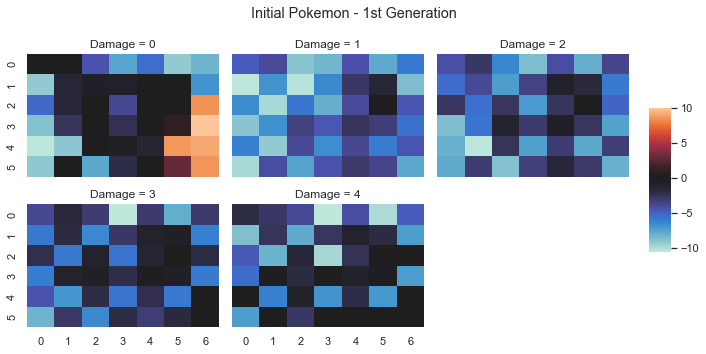

In [128]:
fig, axes = pyplot.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle("Initial Pokemon - 1st Generation")
axes[-1, -1].axis("off")
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

for i, ax in enumerate(axes.flat):
    if i == 5:
        continue
    arr = state_values_q2[i][0]
    arr = np.reshape(arr, (6, 7))
    ax = sns.heatmap(arr, ax=ax, center=0, cbar=i == 0, cbar_ax=None if i else cbar_ax)
    axes[int(i / 3)][i % 3].set_title("Damage = " + str(i))

fig.tight_layout(rect=[0, 0, 0.9, 1])